In [2]:
import numpy as np
import pandas as pd
import pickle
import yaml
import sys
import os

# Add the previous directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from audit import exp_one_acc, exp_all_acc, exp_worst_eps, exp_estimated_epsilon, exp_all_avg_acc, exp_all_group_avg_acc


In [3]:
## get data
def get_one_seed(dataset_name, model_name, method, epsilon, other, seed, configs):
    subdata_dir = f'../{configs["run"]["log_dir"]}{dataset_name}.pkl'
    log_dir = f'../{configs["run"]["log_dir"]}{model_name}/{method}/eps{epsilon}{seed}'
    directories = {
        "log_dir": log_dir,
        "report_dir": f"{log_dir}/report",
        "signal_dir": f"{log_dir}/signals",
    }
    num_group = configs["train"]["num_groups"]

    path = subdata_dir
    if num_group == 2:
        path = f"../data/tabular/{dataset_name}.pkl"
    elif num_group == 5:
        path = f"../data/{dataset_name}.pkl"
    with open(path, "rb") as file:
        dataset = pickle.load(file)

    path = directories["report_dir"]
    memberships = np.load(f"{path}/memberships.npy")
    loss_scores = np.load(f"{path}/loss_scores.npy")


    alooa_adv_group, ga_adv_group, gba_adv_group = [], [], []
    alooa_acc = exp_all_acc(f"{directories['report_dir']}/loss", loss_scores, memberships, dataset, num_group)
    alooa_adv = [[2*value-1 for value in group] for group in alooa_acc]
    alooa_adv_group = [np.mean([value for value in group]) for group in alooa_adv]

    if other:
        ga_acc = exp_all_avg_acc(f"{directories['report_dir']}/loss", loss_scores, memberships, dataset, num_group)
        ga_adv = [[2*value-1 for value in group] for group in ga_acc]
        ga_adv_group = [np.mean([value for value in group]) for group in ga_adv]

        gba_acc = exp_all_group_avg_acc(f"{directories['report_dir']}/loss", loss_scores, memberships, dataset, num_group)
        gba_adv = [[2*value-1 for value in group] for group in gba_acc]
        gba_adv_group = [np.mean([value for value in group]) for group in gba_adv]

    return alooa_adv_group, ga_adv_group, gba_adv_group

def get_all_seeds(dataset_name, model_name, method, epsilon, other=True):
    configs = f"../configs/{dataset_name}/{dataset_name}_regular.yaml"
    if model_name == "LR" and dataset_name != "mnist":
        configs = f"../configs/tabular/{dataset_name}/{dataset_name}_regular.yaml"

    with open(configs, "rb") as f:
        configs = yaml.load(f, Loader=yaml.Loader)

    random_seeds = ["_1", "_12", "_123", "_1234", ""]

    alooa_adv, ga_adv, gba_adv = [], [], []

    for seed in random_seeds:
        alooa_adv_group, ga_adv_group, gba_adv_group = get_one_seed(dataset_name, model_name, method, epsilon, other, seed, configs)
        alooa_adv.append(alooa_adv_group)
        ga_adv.append(ga_adv_group)
        gba_adv.append(gba_adv_group)
    
    return np.array(alooa_adv), np.array(ga_adv), np.array(gba_adv)

In [2]:
dataset_name = "mnist"
model_name = "CNN"
method = "regular"
epsilon = 0

alooa_adv, ga_adv, gba_adv = get_all_seeds(dataset_name, model_name, method, epsilon, other=True)

NameError: name 'get_all_seeds' is not defined

In [26]:
alooa_adv_col_mean = np.mean(alooa_adv, axis=0)
alooa_adv_col_std = np.std(alooa_adv, axis=0)
print(alooa_adv_col_mean, alooa_adv_col_std)

[0.094562 0.088098 0.134492 0.128572 0.114834 0.137275 0.102402 0.116418
 0.1356   0.131657] [0.00136586 0.00087851 0.00086157 0.00078907 0.00114044 0.00124693
 0.00073559 0.00146644 0.00112627 0.00121591]


## mnist delta

In [8]:
dataset_name = "mnist"
model_name = "CNN"
epsilon = 10
method = "regular"
sgd_alooa_adv_cnn, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
sgd_alooa_cnn = np.max(sgd_alooa_adv_cnn, axis=1) - np.min(sgd_alooa_adv_cnn, axis=1)
method = "dpsgd"
dpsgd_alooa_adv_cnn, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgd_alooa_cnn = np.max(dpsgd_alooa_adv_cnn, axis=1) - np.min(dpsgd_alooa_adv_cnn, axis=1)
method = "dpsgds"
dpsgds_alooa_adv_cnn, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgds_alooa_cnn = np.max(dpsgds_alooa_adv_cnn, axis=1) - np.min(dpsgds_alooa_adv_cnn, axis=1)


In [10]:
dataset_name = "mnist"
model_name = "LR"
epsilon = 10
method = "regular"
sgd_alooa_adv_lr, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
sgd_alooa_lr = np.max(sgd_alooa_adv_lr, axis=1) - np.min(sgd_alooa_adv_lr, axis=1)
method = "dpsgd"
dpsgd_alooa_adv_lr, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgd_alooa_lr = np.max(dpsgd_alooa_adv_lr, axis=1) - np.min(dpsgd_alooa_adv_lr, axis=1)
method = "dpsgds"
dpsgds_alooa_adv_lr, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgds_alooa_lr = np.max(dpsgds_alooa_adv_lr, axis=1) - np.min(dpsgds_alooa_adv_lr, axis=1)

In [11]:
dataset_name = "mnist"
model_name = "MLP"
epsilon = 10
method = "regular"
sgd_alooa_adv_mlp, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
sgd_alooa_mlp = np.max(sgd_alooa_adv_mlp, axis=1) - np.min(sgd_alooa_adv_mlp, axis=1)
method = "dpsgd"
dpsgd_alooa_adv_mlp, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgd_alooa_mlp = np.max(dpsgd_alooa_adv_mlp, axis=1) - np.min(dpsgd_alooa_adv_mlp, axis=1)
method = "dpsgds"
dpsgds_alooa_adv_mlp, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
dpsgds_alooa_mlp = np.max(dpsgds_alooa_adv_mlp, axis=1) - np.min(dpsgds_alooa_adv_mlp, axis=1)

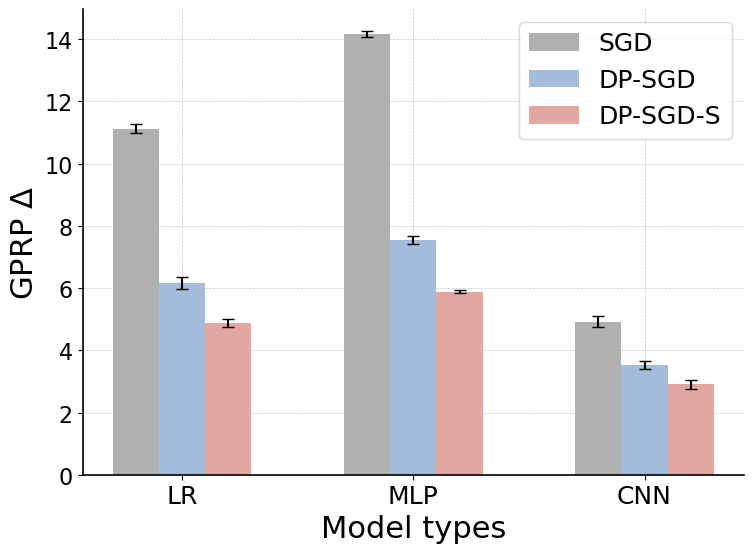

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data
values = {
    "SGD":np.array([np.mean(sgd_alooa_lr, axis=0), np.mean(sgd_alooa_mlp, axis=0) , np.mean(sgd_alooa_cnn, axis=0)]) * 100,
    "DP-SGD":np.array([np.mean(dpsgd_alooa_lr, axis=0), np.mean(dpsgd_alooa_mlp, axis=0), np.mean(dpsgd_alooa_cnn, axis=0)]) * 100,
    "DP-SGD-S":np.array([np.mean(dpsgds_alooa_lr, axis=0), np.mean(dpsgds_alooa_mlp, axis=0), np.mean(dpsgds_alooa_cnn, axis=0)]) * 100,
}
std = {
    "SGD":np.array([np.std(sgd_alooa_lr, axis=0), np.std(sgd_alooa_mlp, axis=0), np.std(sgd_alooa_cnn, axis=0)]) * 100,
    "DP-SGD":np.array([np.std(dpsgd_alooa_lr, axis=0), np.std(dpsgd_alooa_mlp, axis=0), np.std(dpsgd_alooa_cnn, axis=0)]) * 100,
    "DP-SGD-S":np.array([np.std(dpsgds_alooa_lr, axis=0), np.std(dpsgds_alooa_mlp, axis=0), np.std(dpsgds_alooa_cnn, axis=0)]) * 100,
}
x_labels = ["LR", "MLP", "CNN"]
x = np.arange(len(x_labels))  

colors = ["#afb1ae", "#a5bcdc", "#e2a7a1"]
bar_width = 0.2
fig, ax = plt.subplots(figsize=(8, 6))

# font size
plt.rcParams.update({
    "font.size": 22,      # 默认字体大小
    "axes.labelsize": 22, # 坐标轴标签字体大小
    "xtick.labelsize": 18, # x轴刻度字体大小
    "ytick.labelsize": 16  # y轴刻度字体大小
})

# bar chart
for i, (category, values_list) in enumerate(values.items()):
    # ax.bar(x + i * bar_width, values_list, bar_width, label=category, color=colors[i])
    ax.bar(
        x + i * bar_width,
        values_list,
        bar_width,
        label=category,
        color=colors[i],
        yerr=std[category],  # 加上标准差
        capsize=4  # 给误差线加上帽子，数字可以调节误差线末端的小横线长度
    )

ax.set_xlabel("Model types")
ax.set_ylabel(r"GPRP $\Delta$")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=18, frameon=True, loc="upper right")

ax.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7) # 美化网格
ax.set_axisbelow(True)  # 让网格位于柱状图下方

# 设置边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

plt.tight_layout()
# plt.show()

plt.savefig("../exp/demo_mnist/type_compare.pdf", dpi=400, bbox_inches='tight')

## 

## scale

In [19]:
dataset_name = "mnist"
model_name = "CNN"
epsilon = 10

method = "dpsgds_1"
alooa_adv_1, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
alooa_1 = np.max(alooa_adv_1, axis=1) - np.min(alooa_adv_1, axis=1)
method = "dpsgds"
alooa_adv_2, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
alooa_2 = np.max(alooa_adv_2, axis=1) - np.min(alooa_adv_2, axis=1)
method = "dpsgds_3"
alooa_adv_3, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
alooa_3 = np.max(alooa_adv_3, axis=1) - np.min(alooa_adv_3, axis=1)
method = "dpsgds_4"
alooa_adv_4, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
alooa_4 = np.max(alooa_adv_4, axis=1) - np.min(alooa_adv_4, axis=1)
method = "dpsgds_5"
alooa_adv_5, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
alooa_5 = np.max(alooa_adv_5, axis=1) - np.min(alooa_adv_5, axis=1)

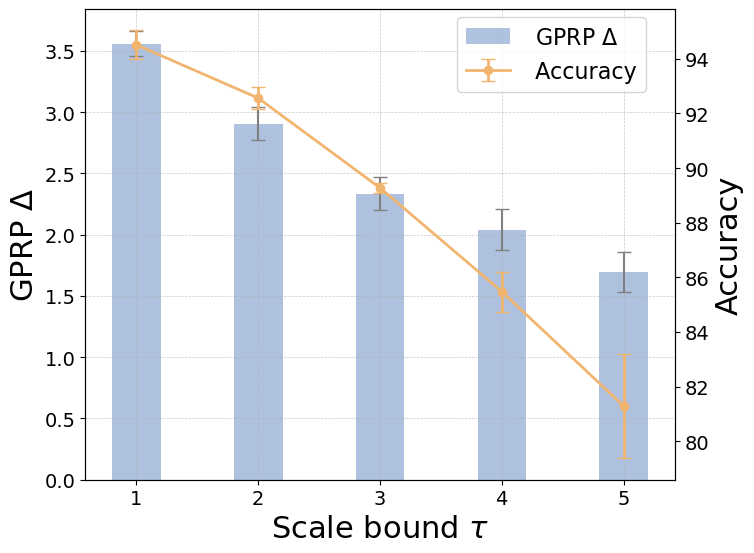

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
x = np.array([1, 2, 3, 4, 5])
delta_mean = np.array([np.mean(alooa_1*100, axis=0), np.mean(alooa_2*100, axis=0), np.mean(alooa_3*100, axis=0), np.mean(alooa_4*100, axis=0), np.mean(alooa_5*100, axis=0)])
delta_std = np.array([np.std(alooa_1*100, axis=0), np.std(alooa_2*100, axis=0), np.std(alooa_3*100, axis=0), np.std(alooa_4*100, axis=0), np.std(alooa_5*100, axis=0)])
accuracy_mean = np.array([0.9451, 0.9256, 0.8927, 0.8547, 0.8128]) *100
accuracy_std = np.array([0.0053, 0.0039, 0.0019, 0.0074, 0.0191]) *100

# 全局字体大小设置
plt.rcParams.update({
    "font.size": 22,      # 默认字体大小
    "axes.labelsize": 22, # 坐标轴标签字体大小
    "xtick.labelsize": 14, # x轴刻度字体大小
    "ytick.labelsize": 14  # y轴刻度字体大小
})
fig, ax1 = plt.subplots(figsize=(8, 6))

# 绘制柱状图（左侧 y 轴）
bar_width = 0.4
# ax1.bar(x, delta, bar_width, label=r" GPRP $\Delta$", color="#a5bcdc", alpha=0.9)
ax1.bar(x, delta_mean, bar_width, yerr=delta_std, capsize=5, label=r" GPRP $\Delta$", 
        color="#a5bcdc", alpha=0.9, error_kw=dict(ecolor='gray', lw=1.5))
        
ax1.set_xlabel(r"Scale bound $\tau$")
ax1.set_ylabel(r"GPRP $\Delta$")
ax1.tick_params(axis="y")
ax1.set_xticks(x)
ax1.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7)

# 添加折线图（右侧 y 轴）
ax2 = ax1.twinx()
ax2.errorbar(x, accuracy_mean, yerr=accuracy_std, fmt="-o", color="#f2b56f", label=r" Accuracy", capsize=5, markersize=6, linewidth=2)
ax2.set_ylabel("Accuracy")
ax2.tick_params(axis="y")

fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.95), fontsize=16, frameon=True)

# 调整布局并显示
plt.tight_layout()
plt.savefig("../exp/demo_mnist/scale_compare.pdf", dpi=400, bbox_inches='tight')


## group risk

In [8]:
dataset_name = "raceface"
model_name = "CNN"
epsilon = 10

method = "dpsgd"
dpsgd_alooa_adv, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)
method = "dpsgds"
dpsgds_alooa_adv, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon, other=False)

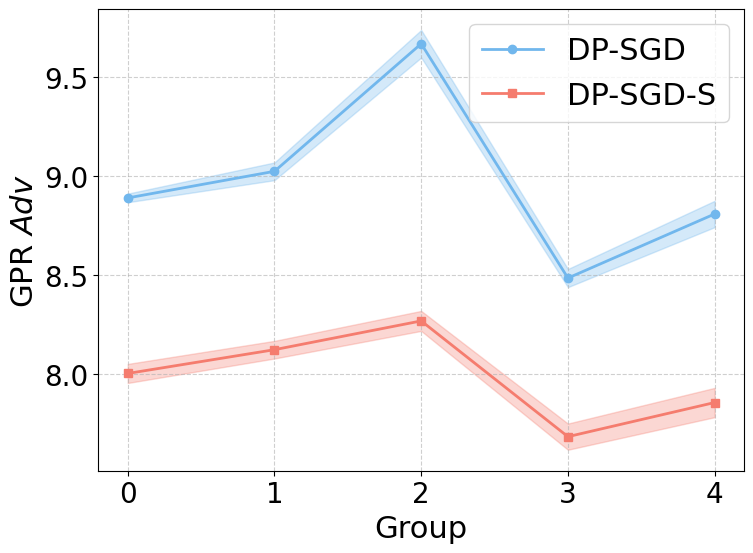

In [9]:
import matplotlib.pyplot as plt

# 数据
x = list(range(0, 5))  # 横坐标 1 到 10
dpsgd_mean = np.mean(dpsgd_alooa_adv*100, axis=0)
dpsgd_std = np.std(dpsgd_alooa_adv*100, axis=0)
dpsgds_mean = np.mean(dpsgds_alooa_adv*100, axis=0)
dpsgds_std = np.std(dpsgds_alooa_adv*100, axis=0)

# 全局字体大小设置
plt.rcParams.update({
    "font.size": 22,      # 默认字体大小 20
    "axes.labelsize": 22, # 坐标轴标签字体大小
    "xtick.labelsize": 20, # x轴刻度字体大小 16
    "ytick.labelsize": 20  # y轴刻度字体大小
})

# 画图
plt.figure(figsize=(8,6)) # 6,4 10, 6
plt.plot(x, dpsgd_mean, label="DP-SGD", color="#71b7ed", marker="o", linestyle="-", linewidth=2)
plt.fill_between(x, dpsgd_mean - dpsgd_std, dpsgd_mean + dpsgd_std, color="#71b7ed", alpha=0.3)
plt.plot(x, dpsgds_mean, label="DP-SGD-S", color="#f57c6e", marker="s", linestyle="-", linewidth=2)
plt.fill_between(x, dpsgds_mean - dpsgds_std, dpsgds_mean + dpsgds_std, color="#f57c6e", alpha=0.3)
# plt.plot(x, dpsgd-dpsgds, label="Difference", color="#f2b56f", marker="s", linestyle="--", linewidth=2)
# 折线图 + 标准差误差线
# plt.errorbar(x, dpsgd_mean, yerr=dpsgd_std, label="DP-SGD", color="#71b7ed",
#              marker="o", linestyle="-", linewidth=2, capsize=4)
# plt.errorbar(x, dpsgds_mean, yerr=dpsgds_std, label="DP-SGD-S", color="#f57c6e",
#              marker="s", linestyle="-", linewidth=2, capsize=4)



# 标题和标签
plt.xlabel("Group")
plt.ylabel(r"GPR $Adv$")
plt.xticks(x)
plt.legend()

# 网格
plt.grid(True, linestyle="--", alpha=0.6)

# 调整布局并显示
plt.tight_layout()
plt.savefig(f"../exp/figs/fig5.3/{dataset_name}_eps{epsilon}_{model_name}.pdf", dpi=400, bbox_inches='tight')


## Adv compare

In [185]:
dataset_name = "mnist"
model_name = "LR"
epsilon = 10
method = "dpsgd"
alooa_adv, ga_adv, gba_adv = get_all_seeds(dataset_name, model_name, method, epsilon, other=True)

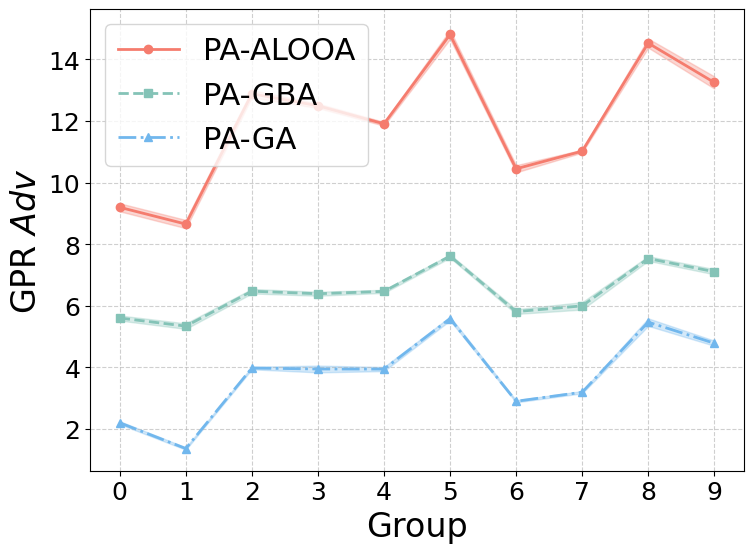

In [186]:
import matplotlib.pyplot as plt

# 数据
x = list(range(0, 10))  # 横坐标 1 到 10
alooa_mean = np.mean(alooa_adv*100, axis=0)
alooa_std = np.std(alooa_adv*100, axis=0)
ga_mean = np.mean(ga_adv*100, axis=0)
ga_std = np.std(ga_adv*100, axis=0)
gba_mean = np.mean(gba_adv*100, axis=0)
gba_std = np.std(gba_adv*100, axis=0)

# 全局字体大小设置
plt.rcParams.update({
    "font.size": 22,      # 默认字体大小
    "axes.labelsize": 24, # 坐标轴标签字体大小
    "xtick.labelsize": 18, # x轴刻度字体大小
    "ytick.labelsize": 18  # y轴刻度字体大小
})

# 画图
plt.figure(figsize=(8, 6)) #6,4 ;8, 6
# plt.plot(x, alooa_mean, label="PA-ALOOA", color="#71b7ed", marker="o", linestyle="-", linewidth=2)
# plt.plot(x, ga_mean, label="PA-GA", color="#f57c6e", marker="^", linestyle="-", linewidth=2)
# plt.plot(x, gba_mean, label="PA-GBA", color="#84c3b7", marker="s", linestyle="-", linewidth=2)
# plt.errorbar(x, alooa_mean, yerr=alooa_std, label="PA-ALOOA", color="#71b7ed", marker="o", linestyle="-", linewidth=2, capsize=5)
# plt.errorbar(x, ga_mean, yerr=ga_std, label="PA-GA", color="#f57c6e", marker="^", linestyle="-", linewidth=2, capsize=5)
# plt.errorbar(x, gba_mean, yerr=gba_std, label="PA-GBA", color="#84c3b7", marker="s", linestyle="-", linewidth=2, capsize=5)
# 绘制带有误差区域的曲线
plt.plot(x, alooa_mean, label="PA-ALOOA", color="#f57c6e", marker="o", linestyle="-", linewidth=2)
plt.fill_between(x, alooa_mean - alooa_std, alooa_mean + alooa_std, color="#f57c6e", alpha=0.3)
plt.plot(x, gba_mean, label="PA-GBA", color="#84c3b7", marker="s", linestyle="--", linewidth=2)
plt.fill_between(x, gba_mean - gba_std, gba_mean + gba_std, color="#84c3b7", alpha=0.3)
plt.plot(x, ga_mean, label="PA-GA", color="#71b7ed", marker="^", linestyle="-.", linewidth=2)
plt.fill_between(x, ga_mean - ga_std, ga_mean + ga_std, color="#71b7ed", alpha=0.3)


# 标题和标签
plt.xlabel("Group")
plt.ylabel(r"GPR $Adv$")
plt.xticks(x)
plt.legend(fontsize=22)

# 网格
plt.grid(True, linestyle="--", alpha=0.6)

# 调整布局并显示
plt.tight_layout()
plt.savefig(f"../exp/figs/fig3.3/{dataset_name}_{model_name}_{method}.pdf", dpi=400, bbox_inches='tight')


## adv_grc compare

In [195]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

model = "LR"

In [196]:
# load norm
path = f'../runs/demo_mnist_compare/{model}/regular/eps0' + '/models'
norm_grad = pd.read_csv(path+"/norm_avg_grad_per_epochs.csv")
norm_clip_grad = pd.read_csv(path+"/norm_clip_avg_grad_per_epochs.csv")

for i in range(10):
    col = f"norm_clip_avg_grad_{i}"
    norm_clip_grad[col] = norm_clip_grad[col] / norm_clip_grad["norm_clip_avg_grad"]

# 选择除 'norm_avg_grad' 之外的所有列
cols_to_plot = norm_clip_grad.drop(norm_clip_grad.columns[:2], axis=1)
#plot_single_vec(norm_grad['epoch'], cols_to_plot, cols_to_plot.columns.tolist())
norm_mean = cols_to_plot.mean().values
norm_last = cols_to_plot.iloc[-1].values
norm_mean, norm_last

path = f'../exp/demo_mnist/{model}/regular/eps0' + '/report'
with open(path+'/loss_acc.pkl', "rb") as file:
    all_acc = pickle.load(file)
all_adv_acc = [[2*value-1 for value in group] for group in all_acc]
group_adv_mean = np.array([np.mean(values) for values in all_adv_acc])
print(group_adv_mean)
print(max(group_adv_mean) - min(group_adv_mean))

[0.123595 0.108455 0.19174  0.1837   0.16758  0.21877  0.148565 0.1544
 0.2174   0.191085]
0.11031500000000001


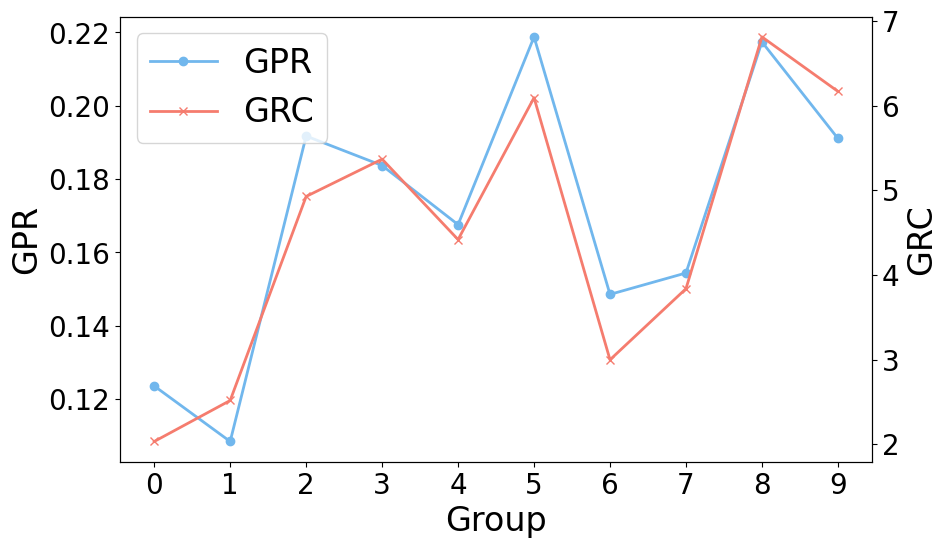

In [197]:
groups = np.arange(10)

# 全局字体大小设置
plt.rcParams.update({
    "font.size": 24,      # 默认字体大小
    "axes.labelsize": 24, # 坐标轴标签字体大小
    "xtick.labelsize": 20, # x轴刻度字体大小
    "ytick.labelsize": 20  # y轴刻度字体大小
})

# 创建一个图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制第一个 y 轴的直方图（group_eps_mean）
# ax1.bar(groups, group_adv_mean, color='#84c3b7', alpha=0.8, label='group_adv_mean')
ax1.plot(groups, group_adv_mean, color='#71b7ed', marker='o', label='GPR', linewidth=2)
ax1.set_xlabel('Group')
ax1.set_ylabel('GPR')
ax1.tick_params(axis='y')

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制第二个 y 轴的折线图（group_norm_mean）
ax2.plot(groups, norm_mean, color='#f57c6e', marker='x', label='GRC', linewidth=2)
ax2.set_ylabel('GRC')
ax2.tick_params(axis='y')

# 合并两个坐标轴的图例，并设置位置
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=24)

# 设置标题
# plt.title('Group-wise Analysis: eps_mean and norm_mean')
plt.xticks(groups)
# plt.legend()
# 网格
# plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
#plt.show()
path = "../exp/figs/fig4.1/" + f"{model}.pdf"
plt.savefig(path, dpi=400, bbox_inches='tight')


### eps vary

In [88]:
dataset_name = "mnist"
model_name = "CNN"
method = "regular"
adv_cnn_0, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
cnn_0 = np.max(adv_cnn_0, axis=1) - np.min(adv_cnn_0, axis=1)
method = "dpsgd" 
adv_cnn_10, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=10, other=False)
cnn_10 = np.max(adv_cnn_10, axis=1) - np.min(adv_cnn_10, axis=1)
adv_cnn_1, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=1, other=False)
cnn_1 = np.max(adv_cnn_1, axis=1) - np.min(adv_cnn_1, axis=1)


In [89]:
dataset_name = "mnist"
model_name = "MLP"
method = "regular"
adv_mlp_0, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
mlp_0 = np.max(adv_mlp_0, axis=1) - np.min(adv_mlp_0, axis=1)
method = "dpsgd" 
adv_mlp_10, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=10, other=False)
mlp_10 = np.max(adv_mlp_10, axis=1) - np.min(adv_mlp_10, axis=1)
adv_mlp_1, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=1, other=False)
mlp_1 = np.max(adv_mlp_1, axis=1) - np.min(adv_mlp_1, axis=1)


In [90]:
dataset_name = "mnist"
model_name = "LR"
method = "regular"
adv_lr_0, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=0, other=False)
lr_0 = np.max(adv_lr_0, axis=1) - np.min(adv_lr_0, axis=1)
method = "dpsgd" 
adv_lr_10, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=10, other=False)
lr_10 = np.max(adv_lr_10, axis=1) - np.min(adv_lr_10, axis=1)
adv_lr_1, _, _ = get_all_seeds(dataset_name, model_name, method, epsilon=1, other=False)
lr_1 = np.max(adv_lr_1, axis=1) - np.min(adv_lr_1, axis=1)


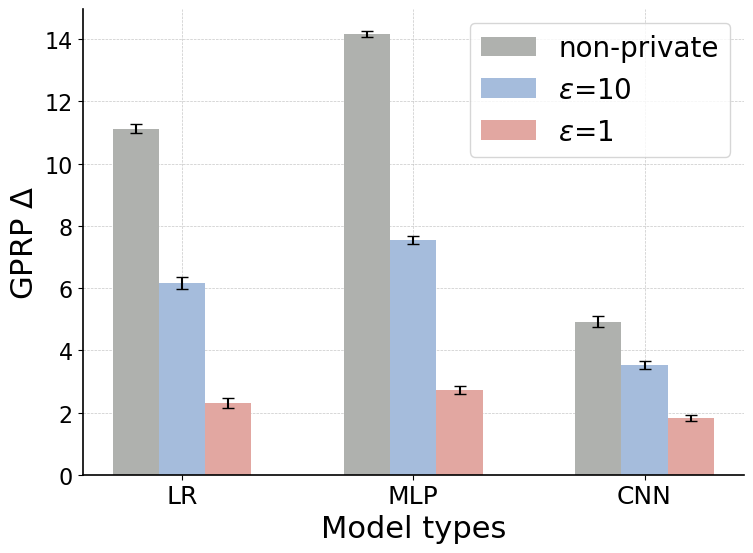

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
x = ["non-private", r"$\epsilon$=10", r"$\epsilon$=1"]
lr_mean = np.array([np.mean(lr_0*100, axis=0), np.mean(lr_10*100, axis=0), np.mean(lr_1*100, axis=0)])
lr_std = np.array([np.std(lr_0*100, axis=0), np.std(lr_10*100, axis=0), np.std(lr_1*100, axis=0)])
mlp_mean = np.array([np.mean(mlp_0*100, axis=0), np.mean(mlp_10*100, axis=0), np.mean(mlp_1*100, axis=0)])
mlp_std = np.array([np.std(mlp_0*100, axis=0), np.std(mlp_10*100, axis=0), np.std(mlp_1*100, axis=0)])
cnn_mean = np.array([np.mean(cnn_0*100, axis=0), np.mean(cnn_10*100, axis=0), np.mean(cnn_1*100, axis=0)])
cnn_std = np.array([np.std(cnn_0*100, axis=0), np.std(cnn_10*100, axis=0), np.std(cnn_1*100, axis=0)])

# data
values = {
    "non-private": np.array([lr_mean[0], mlp_mean[0], cnn_mean[0]]),
    r"$\epsilon$=10": np.array([lr_mean[1], mlp_mean[1], cnn_mean[1]]),
    r"$\epsilon$=1":np.array([lr_mean[2], mlp_mean[2], cnn_mean[2]]),
}
std = {
    "non-private":np.array([lr_std[0], mlp_std[0], cnn_std[0]]),
    r"$\epsilon$=10": np.array([lr_std[1], mlp_std[1], cnn_std[1]]),
    r"$\epsilon$=1":np.array([lr_std[2], mlp_std[2], cnn_std[2]]),
}
x_labels = ["LR", "MLP", "CNN"]
x = np.arange(len(x_labels))  

colors = ["#afb1ae", "#a5bcdc", "#e2a7a1"]
bar_width = 0.2
fig, ax = plt.subplots(figsize=(8, 6))

# font size
plt.rcParams.update({
    "font.size": 22,      # 默认字体大小
    "axes.labelsize": 22, # 坐标轴标签字体大小
    "xtick.labelsize": 18, # x轴刻度字体大小
    "ytick.labelsize": 16  # y轴刻度字体大小
})

# bar chart
for i, (category, values_list) in enumerate(values.items()):
    # ax.bar(x + i * bar_width, values_list, bar_width, label=category, color=colors[i])
    ax.bar(
        x + i * bar_width,
        values_list,
        bar_width,
        label=category,
        color=colors[i],
        yerr=std[category],  # 加上标准差
        capsize=4  # 给误差线加上帽子，数字可以调节误差线末端的小横线长度
    )

ax.set_xlabel("Model types")
ax.set_ylabel(r"GPRP $\Delta$")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=20, frameon=True, loc="upper right")

ax.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7) # 美化网格
ax.set_axisbelow(True)  # 让网格位于柱状图下方

# 设置边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

# 调整布局并显示
plt.tight_layout()
plt.savefig(f"../exp/demo_mnist/eps_compare.pdf", dpi=400, bbox_inches='tight')
